In [13]:
# Imports
%matplotlib notebook
import random
import sys
import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# import seaborn as sns
import time
import csv
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from PIL import Image
import pandas as pd

np.random.seed(42)

In [14]:
my_data_x = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_x.csv', delimiter=',')
my_data_y = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_y.csv', delimiter=',')
my_data_z = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_z.csv', delimiter=',')


# Load MagImage for deciding that where the data is and getting the width and Height of map
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data
gray_img = load_image('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_map.png')
(g_height,g_width, channel_size)=gray_img.shape

mag_training_data_xy = []
mag_training_data_z = []
for i in range(g_height):
    for j in range(g_width):
        if gray_img[i][j][0]!=0.0:
            mag_training_data_xy.append([i*0.5, j*0.5]) # 0.5 means resolution when build magnetic map
            m_mag_vec = []
            m_mag_vec.append(my_data_x[i][j]*10+10)
            m_mag_vec.append(my_data_y[i][j]*10+10)
            m_mag_vec.append(my_data_z[i][j]*10+10)
            mag_training_data_z.append(m_mag_vec)
#             mag_training_data_z.append(my_data_x[i][j]+10)
mag_training_data_xy = np.asarray(mag_training_data_xy)
mag_training_data_z = np.asarray(mag_training_data_z)
data_size = mag_training_data_z.shape[0]

In [15]:
def calculate_dis(current_pos, data_pos):
    return math.hypot((current_pos[0]-data_pos[0]), current_pos[1]-data_pos[1])

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

batch_training_data_xy = np.empty(0)
batch_training_data_z = np.empty(0)


In [17]:
start_time = time.time()
gp.fit(mag_training_data_xy, mag_training_data_z)
print("---Pred: %s seconds ---" % (time.time() - start_time))


min_x = np.amin(mag_training_data_xy[:,0])
max_x = np.amax(mag_training_data_xy[:,0])
min_y = np.amin(mag_training_data_xy[:,1])
max_y = np.amax(mag_training_data_xy[:,1])

batch_data_x_size = int(round((max_x-min_x)/0.5))
batch_test_data_range_x =np.linspace(min_x, max_x, batch_data_x_size)
batch_data_y_size = int(round((max_y-min_y)/0.5))
batch_test_data_range_y =np.linspace(min_y, max_y, batch_data_y_size)

batch_test_data = np.zeros([batch_data_x_size*batch_data_y_size,2])
for m in range(batch_data_y_size):
    for n in range(batch_data_x_size):
        batch_test_data[m*batch_data_x_size+n][0] = batch_test_data_range_x[n]
        batch_test_data[m*batch_data_x_size+n][1] = batch_test_data_range_y[m]

start_time = time.time()
y_pred, sigma = gp.predict(batch_test_data, return_std=True)
print("---Fit:  %s seconds ---" % (time.time() - start_time))

---Pred: 19.42969250679016 seconds ---
---Fit:  0.3437175750732422 seconds ---


<IPython.core.display.Javascript object>


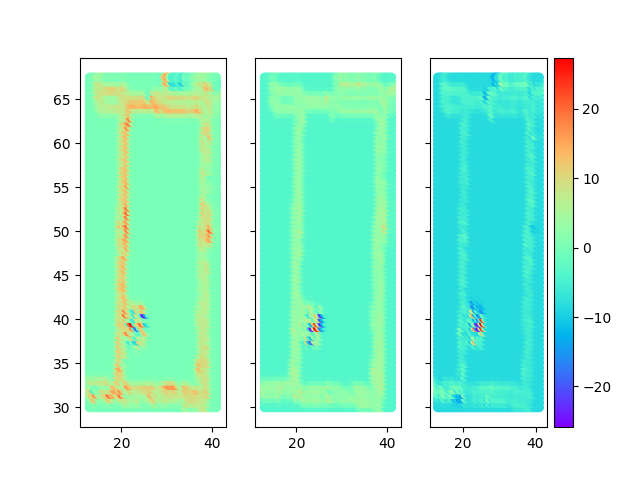

In [18]:
my_draw_test_data_x = batch_test_data[:,0].reshape(batch_data_x_size*batch_data_y_size,1)
my_draw_test_data_y = batch_test_data[:,1].reshape(batch_data_x_size*batch_data_y_size,1)
my_test_predict_zx = y_pred[:,0].reshape(batch_data_x_size*batch_data_y_size,1)
my_test_predict_zy = y_pred[:,1].reshape(batch_data_x_size*batch_data_y_size,1)
my_test_predict_zz = y_pred[:,2].reshape(batch_data_x_size*batch_data_y_size,1)

# fig, ax = plt.subplots()
# _min, _max = np.amin(mag_training_data_z), np.amax(mag_training_data_z)
# sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zz, cmap='rainbow', vmin = _min, vmax = _max)
# plt.colorbar()

f, axes = plt.subplots(nrows = 1, ncols = 3, sharex=True, sharey = True)
_min, _max = np.amin(my_test_predict_zx), np.amax(my_test_predict_zx)
sc = axes[0].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zx, cmap='rainbow', vmin = _min, vmax = _max)
_min, _max = np.amin(my_test_predict_zy), np.amax(my_test_predict_zy)
axes[1].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zy, cmap='rainbow', vmin = _min, vmax = _max)
_min, _max = np.amin(my_test_predict_zz), np.amax(my_test_predict_zz)
axes[2].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zz, cmap='rainbow', vmin = _min, vmax = _max)
f.colorbar(sc)

# sc = plt.scatter(batch_training_data_xy[:,0], batch_training_data_xy[:,1], c=batch_training_data_z, cmap='rainbow', vmin = _min, vmax = _max)
# plt.plot(mag_training_data_xy[:,0], mag_training_data_xy[:,1], 'ko')
# for i in range(len(batch_training_data_z)):
#     ax.annotate(round(batch_training_data_z[i],3), xy=(batch_training_data_xy[i][0],batch_training_data_xy[i][1]), color='black', 
#             xytext=(5,5), textcoords="offset points")
# plt.savefig("scikit_GP_result.png")
plt.show()

In [23]:
y_pred = y_pred.reshape(batch_data_x_size,batch_data_y_size,3)
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_x.csv", y_pred[:,:,0], delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_y.csv", y_pred[:,:,1], delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_z.csv", y_pred[:,:,2], delimiter=",")
